
# **Grupo 3 - Utilizando Algoritmo de Grover para encontrar números aleatórios**


**Objetivo:**
Nosso projeto tem como objetivo utilizar o princípio do Algorítmo de Grover para encontrar, de forma mais rápida e precisa que um algorítmo clássico, um número gerado aleatoriamente utlizando o conceito de superposição de estados quânticos de um qubit.

**Resultados esperados:**
É esperado que o algorítmo quântico seja capaz de encontrar o número gerado aleatoriamente utilizando-se de muito menos tentativas que um algorítmo clássico.

---



In [ ]:
#instalando a biblioteca qiskit
!pip install -q qiskit qiskit-aer pylatexenc matplotlib

In [ ]:
#importando bibliotecas necessárias
%matplotlib inline
import qiskit, math
from IPython.display import display
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import *
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere, plot_state_city, plot_histogram
from qiskit_aer import Aer, AerSimulator
from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
import random
import matplotlib.pyplot as plt

O Algoritmo de Grover é utilizado para fazer pesquisas em bancos de dados muito extensos de forma muito mais rápida que o método tradicional clássico, utilizando o princípio da interferência quântica.

Interferência Quântica: Os qubits operam a partir do princípio da dualidade da onda-partícula. Graças a isso, utilizaremos a propriedade de onda dos qubits para fazer uma interferência de ondas.

Este algoritmo pode ser dividido em 6 passos:

1 - Input:O algoritmo recebe um input com o item que desejamos encontrar dentro de uma lista.

2 - Inicialização: Colocamos todos os qubits em estado de superposição para aplicarmos nossas ondas transformadas pelo Oráculo e Difusor. Para isso, aplicamos a porta Hadamard em todas elas.

3 - Oráculo: O Oráculo tem a principal função de receber o input e inverter a fase do seu estado.

4 - Difusor: O Difusor vai aplicar uma inversão de onda, fazendo com que haja interferência construtiva em cima da onda invertida (representada por Y na imagem abaixo) e interferência destrutiva nas demais ondas.
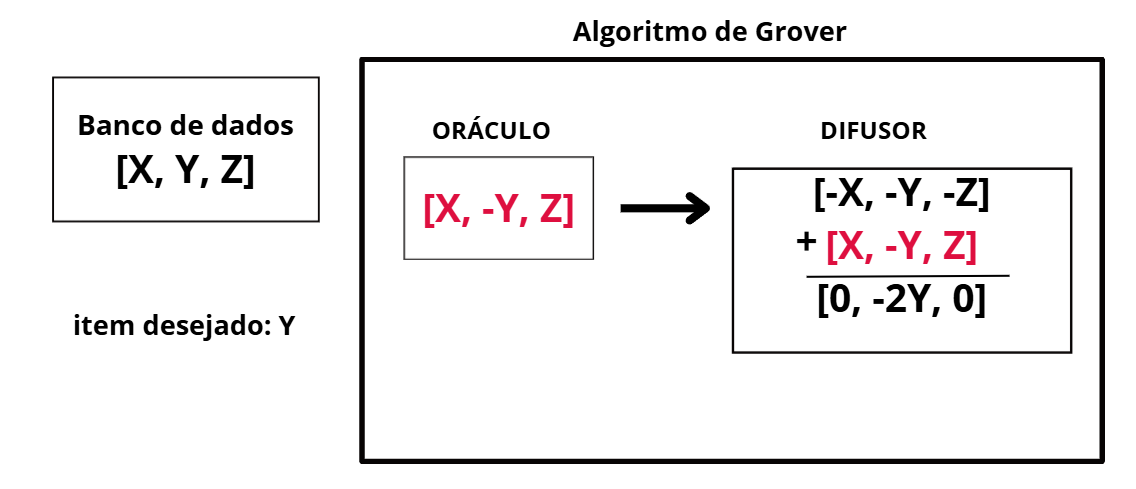

Atenção! Essa imagem não representa o algoritmo de forma fiel. É apenas uma representação visual fazendo uma analogia simplificada com fins didáticos.

5 - Iteração: Esta etapa consiste na repetição do ciclo Oráculo (Etapa 3) e Difusor (Etapa 4). A cada passagem, a amplitude de probabilidade do estado da solução é amplificada por meio de interferência construtiva, garantindo que a probabilidade de medir o resultado correto seja maximizada.

6 - Conversão: Nessa etapa, depois que os qubits passarem por todo o algoritmo, vamos converter esses qubits para bits clássicos, fornecendo o resultado esperado, ou seja, a localização do nosso output.


In [6]:
#etapa 1- input
num_qubits = 8  # número de qubits (define o tamanho da senha em bits)
senha = random.randint(0, 2** num_qubits - 1)  # senha aleatória entre 0 e 2^num_qubits - 1

#etapa 2 - oráculo (inversor de input)
def oracle(circuit, senha_bin):
    # Prepara: inverte qubits onde a senha tem 0
    for i, bit in enumerate(reversed(senha_bin)):
        if bit == '0':
            circuit.x(i)
    # Marca a solução (controle multi-qubit)
    circuit.h(num_qubits - 1)
    circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    circuit.h(num_qubits - 1)

    # Desfaz a preparação
    for i, bit in enumerate(reversed(senha_bin)):
        if bit == '0':
            circuit.x(i)

#etapa 3 - difusor (aplica inversão em todos os qubits)
def diffuser(circuit):
    # Difusor (inversão sobre a média)
    circuit.h(range(num_qubits))
    circuit.x(range(num_qubits))
    circuit.h(num_qubits - 1)
    circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    circuit.h(num_qubits - 1)
    circuit.x(range(num_qubits))
    circuit.h(range(num_qubits))
sim = AerSimulator()

#for senha in range(2**num_qubits):
senha_bin = format(senha, f'0{num_qubits}b')


qr = QuantumRegister(num_qubits)  # registrador quântico
cr = ClassicalRegister(num_qubits)  # registrador clássico
circuit = QuantumCircuit(qr, cr)  # circuito

#etapa 4 - inicialização (colocar todos os qubits em superposição)
circuit.h(qr)

#etapa 5 - iteração (roda as etapas 3 e 2 em loop)
iterations = int(np.pi / 4 * np.sqrt(2 ** num_qubits))
for _ in range(iterations):  # oracle + difusor
    oracle(circuit, senha_bin)
    diffuser(circuit)


#etapa 6 - transformação de qubits em bits clássicos
circuit.measure(qr, cr)

# Execução
compiled = transpile(circuit, sim)
job = sim.run(compiled, shots=1000)
result = job.result()
counts = result.get_counts()




Agora vamos comparar os resultados gerados pelo Algoritmo de Grover com um algoritmo clássico.

In [7]:
#--------------------------------------------------

tentativas_classicas = 0  # força bruta
todas_as_senhas = list(range(0, 2** num_qubits))  # espaço de busca
random.shuffle(todas_as_senhas)  # embaralha
for tentativa in todas_as_senhas:  # busca clássica
    tentativas_classicas += 1
    if tentativa == senha:
        tentativa_bruta = tentativa
        break

print(f"Senha: {senha} (binário: {senha_bin})")

print("\nAlgoritmo clássico:")  # resultado clássico
print(f"Senha encontrada: {tentativa_bruta}")
print(f"Tentativas necessárias: {tentativas_classicas}")

# --- Quantum search result ---
print("\nAlgoritmo quântico:")  # resultado quântico

# Resultado mais provável
quantum_found = max(counts, key=counts.get)  # bitstring
quantum_prob = counts[quantum_found] / sum(counts.values())  # prob

print(f"Senha encontrada: {int(quantum_found, 2)}")
print(f"Probabilidade de acerto: {quantum_prob:.2%}")
print(f"Número de iterações (Grover): {iterations}")

Senha: 243 (binário: 11110011)

Algoritmo clássico:
Senha encontrada: 243
Tentativas necessárias: 192

Algoritmo quântico:
Senha encontrada: 243
Probabilidade de acerto: 100.00%
Número de iterações (Grover): 12


# Conclusão, análise de resultados e expectativas

A partir dos resultados, conseguimos ver que o Algoritmo de Grover conseguiu encontrar o input (senha) em uma quantidade extremamente menor que o algoritmo clássico. Isso se deve a propriedade do Algoritmo de Grover de conseguir chegar a um resultado de uma lista N percorrendo, no pior dos casos, 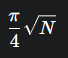
vezes, enquanto um algoritmo clássico, no pior dos casos, percorreria a lista toda, ou seja, N vezes.


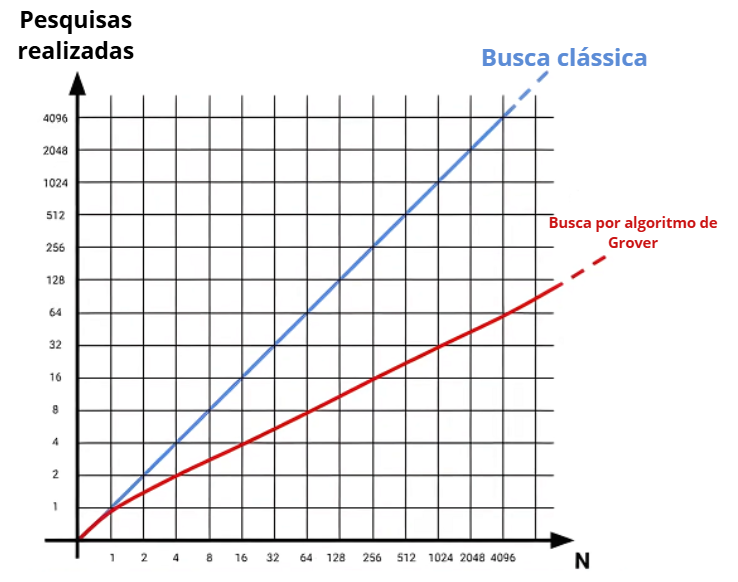

A quantidade de qubits que podemos simular em um computador clássico é fisicamente limitada devido à grande quantidade de memória necessária no processo de simulação. Ainda assim, é possível perceber como a Computação Quântica é extremamente eficaz e mais eficiente do que a computação clássica.

Algoritmos como o de Grover podem ser extremamente úteis para tarefas em diversas áreas, tais como:

* **Análise de Dados:** Pode ser usado para acelerar a busca por uma informação específica em um banco de dados não estruturado. Um exemplo seria localizar uma transação bancária específica (feita por um cliente) em um extrato gigantesco que contenha todas as transferências de todos os clientes do banco.

* **Cibersegurança:** Pode ser utilizado para mensurar a segurança de um sistema de criptografia ao determinar a quantidade de iterações necessárias para encontrar a chave correta (quebrando a criptografia por força bruta).


Explorar as propriedades de onda dos qubits e utilizar sistemas quânticos para aproximar diferentes resultados pode nos ajudar a resolver cálculos extensos com diversas soluções em um tempo exponencialmente menor do que em computadores clássicos.

A Física Quântica abre diversas portas para áreas como Cibersegurança, Criptografia, Análise de Dados e Matemática em geral.